In [78]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [79]:
user = pd.read_csv('~/Documents/Thesis/wheelchair_router/collab/pg/users.csv',
                   usecols=['user_id', 'gender', 'age', 'wheelchair_type'],
                   sep=',', error_bad_lines=False, encoding="latin-1")
user.columns = ['user_id', 'gender', 'age', 'wheelchair_type']
rating = pd.read_csv('~/Documents/Thesis/wheelchair_router/collab/pg/route_ratings.csv',
                     usecols=['route_id', 'user_id', 'rating'],
                     sep=',', error_bad_lines=False, encoding="latin-1")
rating.columns = ['route_id', 'user_id', 'rating']
df = pd.merge(user, rating, on='user_id', how='inner')
#df.drop(['user_id', 'Age'], axis=1, inplace=True)
df.head()

,user_id,gender,age,wheelchair_type,route_id,rating
0,4,Female,30,Electric,65,3
1,4,Female,30,Electric,63,2
2,4,Female,30,Electric,53,5
3,38,Unspecified,0,NaN,64,2
4,38,Unspecified,0,NaN,165,3


In [80]:
min_route_ratings = 2
filter_routes = df['route_id'].value_counts() > min_book_ratings
filter_routes = filter_routes[filter_routes].index.tolist()
filter_routes

[165, 166, 53, 65, 148, 171]

In [81]:
min_user_ratings = 2
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()
filter_users

[57, 56, 13, 38, 4]

In [82]:
df_new = df[(df['route_id'].isin(filter_routes)) & (df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(41, 6)
The new data frame shape:	(25, 6)


In [83]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_new[['user_id', 'route_id', 'rating']], reader)

In [84]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
NMF,0.968201,0.004036,0.000371
KNNBaseline,1.100763,0.000545,0.000338
SVDpp,1.168434,0.005806,0.000466
SlopeOne,1.171786,0.000198,0.000207
SVD,1.172434,0.002439,0.001594
BaselineOnly,1.220826,0.000246,0.000087
KNNWithMeans,1.246666,0.000278,0.000116
KNNWithZScore,1.290059,0.001434,0.000307
KNNBasic,1.408692,0.000670,0.000245


In [85]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([1.1143087 , 1.07312708, 1.23531508]),
 'fit_time': (0.00020766258239746094,
  0.0005636215209960938,
  0.0002238750457763672),
 'test_time': (0.0007352828979492188,
  0.00010251998901367188,
  7.915496826171875e-05)}

In [86]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.1218


1.1217990774491606

In [87]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

In [88]:
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [89]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2,13,148,3.0,2.888297,{'was_impossible': False},4,1,0.111703
3,13,148,3.0,2.888297,{'was_impossible': False},4,1,0.111703
6,56,171,2.0,2.408410,{'was_impossible': False},4,2,0.408410
0,13,53,4.0,3.395829,{'was_impossible': False},4,3,0.604171
4,57,166,4.0,2.856619,{'was_impossible': False},6,3,1.143381
1,57,65,1.0,2.533250,{'was_impossible': False},6,2,1.533250
5,57,166,5.0,2.856619,{'was_impossible': False},6,3,2.143381


In [90]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2,13,148,3.0,2.888297,{'was_impossible': False},4,1,0.111703
3,13,148,3.0,2.888297,{'was_impossible': False},4,1,0.111703
6,56,171,2.0,2.408410,{'was_impossible': False},4,2,0.408410
0,13,53,4.0,3.395829,{'was_impossible': False},4,3,0.604171
4,57,166,4.0,2.856619,{'was_impossible': False},6,3,1.143381
1,57,65,1.0,2.533250,{'was_impossible': False},6,2,1.533250
5,57,166,5.0,2.856619,{'was_impossible': False},6,3,2.143381


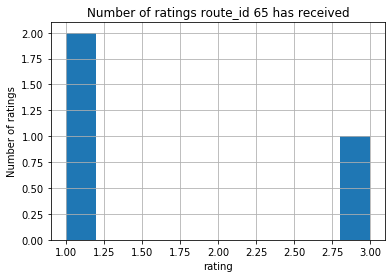

In [92]:
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

df_new.loc[df_new['route_id'] == 65]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings route_id 65 has received')
plt.show();